<a href="https://colab.research.google.com/github/Reza-Pourang/Finance-Customer-Segmentation/blob/main/ML_Project_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries

import numpy as np
import pandas as pd

#Loading dataset
from google.colab import drive
drive.mount('/content/drive')
Data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CleanedBank.csv')

Mounted at /content/drive


In [ ]:
#Initial check

print(Data.head(20))
print('\n')
print(Data.dtypes)
print('\n')
print(Data.info())
print('\n')
print(Data.isnull().sum())
print('\n')
print(Data.duplicated().sum())

    age           job   marital  education default  balance housing loan  \
0    58    management   married   tertiary      no     2143     yes   no   
1    44    technician    single  secondary      no       29     yes   no   
2    33  entrepreneur   married  secondary      no        2     yes  yes   
3    35    management   married   tertiary      no      231     yes   no   
4    28    management    single   tertiary      no      447     yes  yes   
5    42  entrepreneur  divorced   tertiary     yes        2     yes   no   
6    58       retired   married    primary      no      121     yes   no   
7    43    technician    single  secondary      no      593     yes   no   
8    41        admin.  divorced  secondary      no      270     yes   no   
9    29        admin.    single  secondary      no      390     yes   no   
10   53    technician   married  secondary      no        6     yes   no   
11   57      services   married  secondary      no      162     yes   no   
12   51     

In [ ]:
#Preprocessing: Encode Categorical Variables

from sklearn.preprocessing import LabelEncoder

#One-Hot Encoding for nominal variables
DataEncoded = pd.get_dummies(Data, columns = ['job', 'marital', 'poutcome'], drop_first=True)

#Label Encoding for ordinal and binary variables
LE = LabelEncoder()
ColumnstoLE = ["education", "default", "housing", "loan", "y"]
for col in ColumnstoLE:
  DataEncoded[col] = LE.fit_transform(DataEncoded[col])

print(DataEncoded.head())

   age  education  default  balance  housing  loan  campaign  pdays  previous  \
0   58          2        0     2143        1     0         1     -1         0   
1   44          1        0       29        1     0         1     -1         0   
2   33          1        0        2        1     1         1     -1         0   
3   35          2        0      231        1     0         1     -1         0   
4   28          2        0      447        1     1         1     -1         0   

   y  ...  job_self-employed  job_services  job_student  job_technician  \
0  0  ...              False         False        False           False   
1  0  ...              False         False        False            True   
2  0  ...              False         False        False           False   
3  0  ...              False         False        False           False   
4  0  ...              False         False        False           False   

   job_unemployed  marital_married  marital_single  poutcome_o

In [ ]:
#Preprocessing: Scale Numerical Features

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Create a binary indicator for 'pdays'
DataEncoded['Contacted_before'] = DataEncoded['pdays'].apply(lambda x: 1 if x > -1 else 0)

#Keep -1 in 'pdays' and scale it by MinMaxScaler
MinMax = MinMaxScaler()
DataEncoded['pdays'] = MinMax.fit_transform(DataEncoded[['pdays']])

#Scale numerical features
NumericalColumns = ['age', 'balance', 'campaign', 'pdays', 'previous']
Scaler = StandardScaler()
DataEncoded[NumericalColumns] = Scaler.fit_transform(DataEncoded[NumericalColumns])

print(DataEncoded.head())

        age  education  default   balance  housing  loan  campaign     pdays  \
0  1.639561          2        0  0.259354        1     0 -0.573827 -0.412311   
1  0.307816          1        0 -0.435568        1     0 -0.573827 -0.412311   
2 -0.738556          1        0 -0.444443        1     1 -0.573827 -0.412311   
3 -0.548306          2        0 -0.369166        1     0 -0.573827 -0.412311   
4 -1.214179          2        0 -0.298161        1     1 -0.573827 -0.412311   

   previous  y  ...  job_services  job_student  job_technician  \
0  -0.25073  0  ...         False        False           False   
1  -0.25073  0  ...         False        False            True   
2  -0.25073  0  ...         False        False           False   
3  -0.25073  0  ...         False        False           False   
4  -0.25073  0  ...         False        False           False   

   job_unemployed  marital_married  marital_single  poutcome_other  \
0           False             True           False  

In [ ]:
#Preprocessing: Feature Engineering

from sklearn.preprocessing import MinMaxScaler

#How financial stability varies by age?
DataEncoded['AgeBalance'] = DataEncoded['age'] * DataEncoded['balance']
DataEncoded['AgeBalance'] = MinMaxScaler().fit_transform(DataEncoded[['AgeBalance']])

#Identify customers with zero balance or campaign
DataEncoded['ZeroBalance'] = (DataEncoded['balance'] == 0).astype(int)
DataEncoded['ZeroCampaign'] = (DataEncoded['campaign'] == 0).astype(int)

print(DataEncoded[['AgeBalance', 'ZeroBalance', 'ZeroCampaign']].head())

   AgeBalance  ZeroBalance  ZeroCampaign
0    0.132340            0             0
1    0.127827            0             0
2    0.131557            0             0
3    0.130542            0             0
4    0.131830            0             0


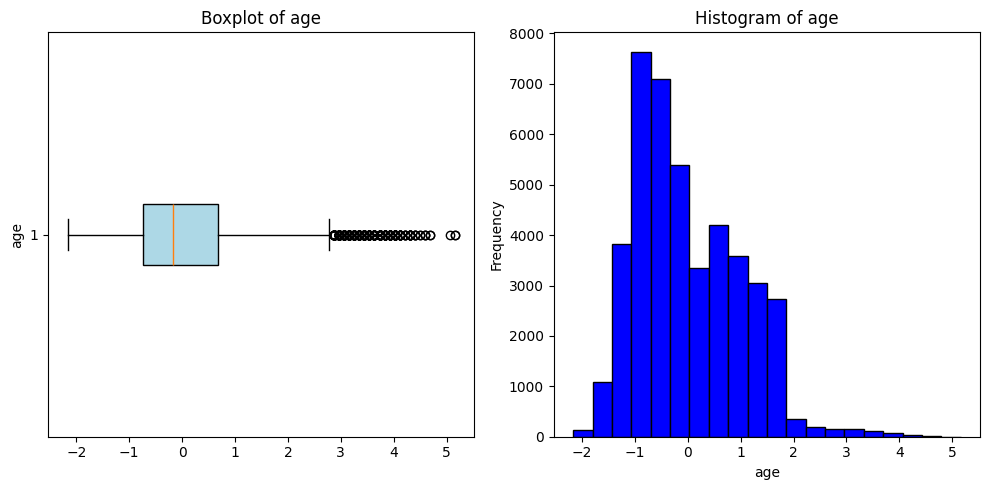

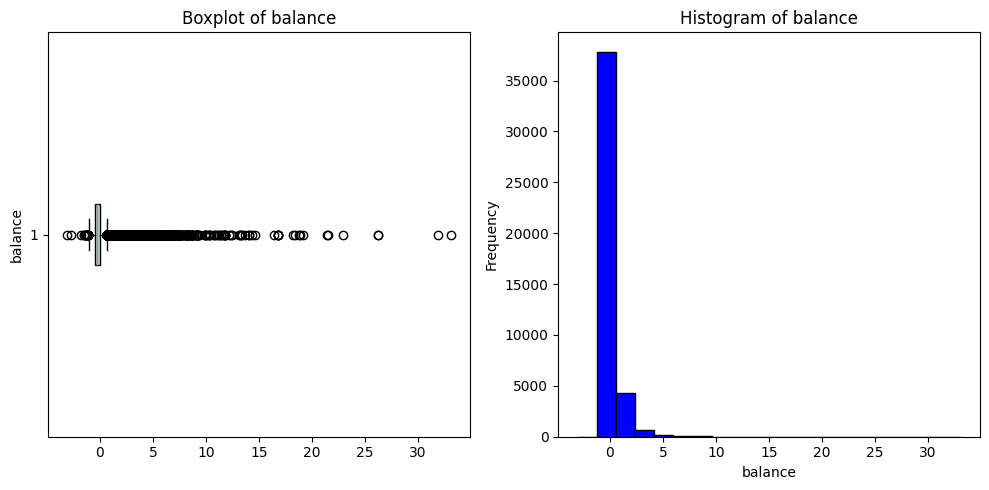

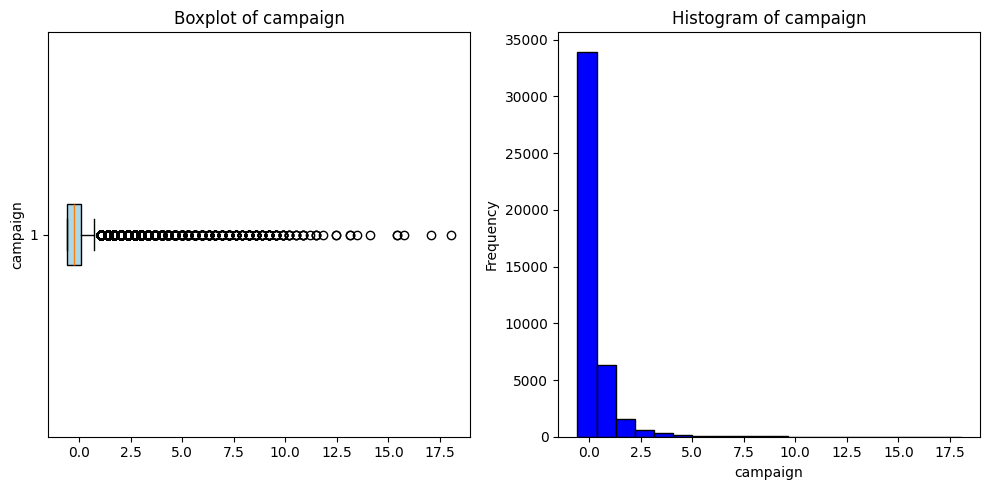

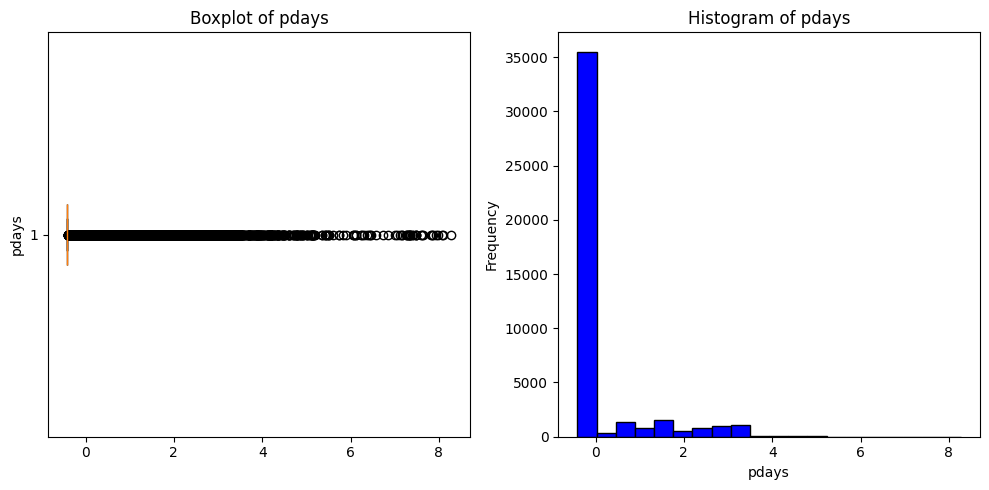

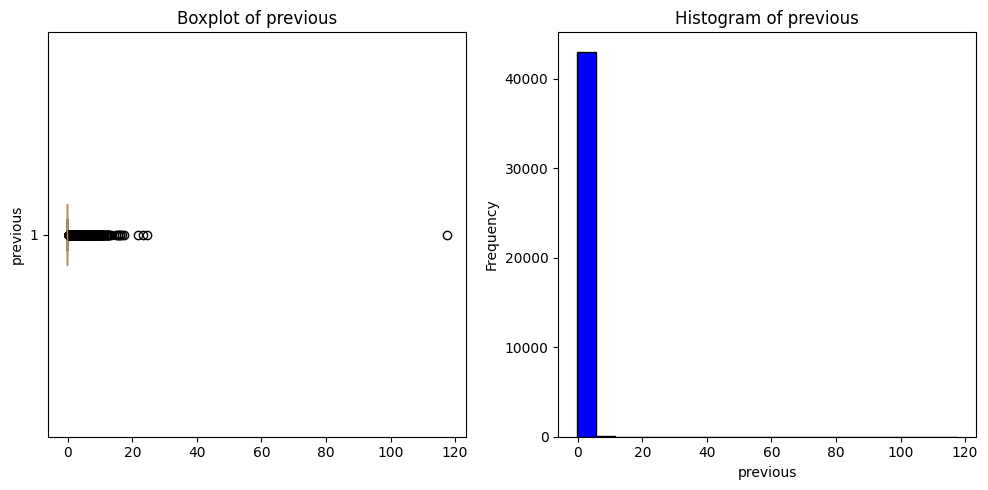

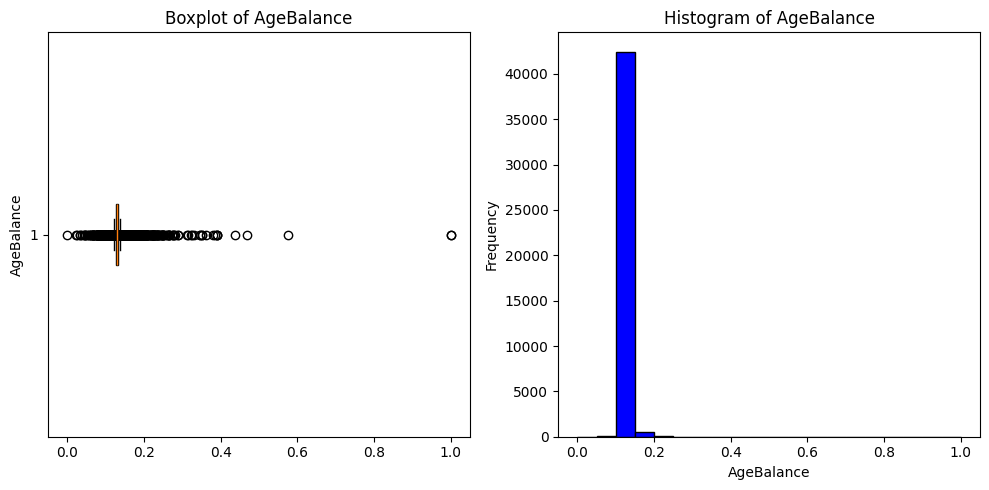

In [ ]:
#Analyze Outliers

import matplotlib.pyplot as plt

NumericalData = ["age", "balance", "campaign", "pdays", "previous", "AgeBalance"]

#Create boxplots and histograms for each column

for column in NumericalData:
  plt.figure(figsize=(10,5))

  #Box
  plt.subplot(1,2,1)
  plt.boxplot(DataEncoded[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
  plt.ylabel(column)
  plt.title(f'Boxplot of {column}')

  #Histogram
  plt.subplot(1,2,2)
  plt.hist(DataEncoded[column], bins=20, color='blue', edgecolor='black')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {column}')

  plt.tight_layout()
  plt.show()

In [ ]:
#Calculate outlier statistics for numerical columns
NumericalData = ["age", "balance", "campaign", "pdays", "previous", "AgeBalance"]

OutlierStats = {}

for column in NumericalData:
    Q1 = DataEncoded[column].quantile(0.25)
    Q3 = DataEncoded[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Count outliers
    Below = (DataEncoded[column] < lower_bound).sum()
    Above = (DataEncoded[column] > upper_bound).sum()
    Total = Below + Above

    #Save statistics
    OutlierStats[column] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outliers Below": Below,
        "Outliers Above": Above,
        "Total Outliers": Total,
        "Outlier Percentage": (Total / len(DataEncoded)) * 100 }

OutlierStats_DF = pd.DataFrame(OutlierStats).T
OutlierStats_DF

,Q1,Q3,IQR,Lower Bound,Upper Bound,Outliers Below,Outliers Above,Total Outliers,Outlier Percentage
age,-0.738556,0.688314,1.426870,-2.878861,2.828620,0.0,434.0,434.0,1.004792
balance,-0.421762,0.019057,0.440818,-1.082989,0.680285,19.0,4526.0,4545.0,10.522538
campaign,-0.573827,0.078925,0.652752,-1.552955,1.058053,0.0,4134.0,4134.0,9.570995
pdays,-0.412311,-0.412311,0.000000,-0.412311,-0.412311,0.0,7912.0,7912.0,18.317783
previous,-0.250730,-0.250730,0.000000,-0.250730,-0.250730,0.0,7912.0,7912.0,18.317783
AgeBalance,0.127425,0.131202,0.003777,0.121759,0.136867,1406.0,1665.0,3071.0,7.109948


In [ ]:
#Check for missing values
print("Missing values:\n", DataEncoded.isnull().sum())

#Check dataset shape
print("Dataset shape:", DataEncoded.shape)

#Check data types and basic statistics
print("Data types:\n", DataEncoded.dtypes)
print("\nBasic statistics:\n", DataEncoded.describe())

Missing values:
 age                  0
education            0
default              0
balance              0
housing              0
loan                 0
campaign             0
pdays                0
previous             0
y                    0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
job_unemployed       0
marital_married      0
marital_single       0
poutcome_other       0
poutcome_success     0
poutcome_unknown     0
Contacted_before     0
AgeBalance           0
ZeroBalance          0
ZeroCampaign         0
dtype: int64
Dataset shape: (43193, 29)
Data types:
 age                  float64
education              int64
default                int64
balance              float64
housing                int64
loan                   int64
campaign             float64
pdays                float64
previous             float64
y 

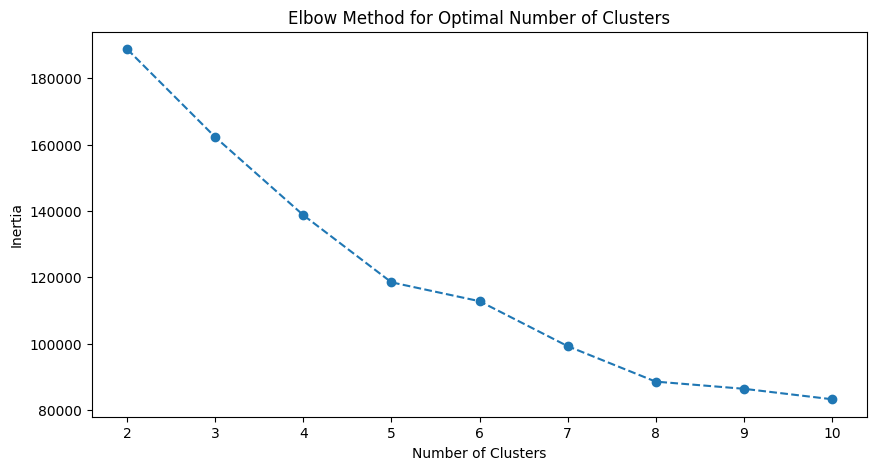

In [ ]:
#K-Means clustering- Elbow method

ClusteringFeatures = ['age', 'education', 'balance', 'campaign', 'pdays', 'previous',
                      'Contacted_before', 'AgeBalance']

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

interia = []
RangeClusters = range(2,11)
for n_clusters in RangeClusters:
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(DataEncoded[ClusteringFeatures])
  interia.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(RangeClusters, interia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [ ]:
#Apply K-Means clustering (based on the optimal number = 5)

from sklearn.metrics import silhouette_score

OptimalClusters = 5
kmeans = KMeans(n_clusters=OptimalClusters, random_state=42)
DataEncoded['Cluster'] = kmeans.fit_predict(DataEncoded[ClusteringFeatures])
print(DataEncoded['Cluster'].value_counts())
print('\n')

#Cluster summary
ClusterSummary = DataEncoded.groupby('Cluster')[ClusteringFeatures].mean()
print(ClusterSummary)

#Evaluate Segmentation- Silhouette Score
SilhouetteScore = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster'])
print("Silhouette Score:", SilhouetteScore)

Cluster
3    21057
0    13168
1     6419
2     1573
4      976
Name: count, dtype: int64


              age  education   balance  campaign     pdays  previous  \
Cluster                                                                
0        1.091518   0.955118 -0.053958 -0.102109 -0.357694 -0.207430   
1       -0.114414   1.183050 -0.051250 -0.215978  2.122194  1.240797   
2       -0.066696   1.177368 -0.137984  3.874886 -0.401802 -0.239011   
3       -0.655226   1.247424 -0.157900 -0.155724 -0.388071 -0.228803   
4        0.269805   1.398566  4.694095 -0.087273 -0.111269 -0.040334   

         Contacted_before  AgeBalance  
Cluster                                
0                0.050577    0.128748  
1                1.000000    0.129288  
2                0.008264    0.129329  
3                0.030346    0.129773  
4                0.179303    0.144101  
Silhouette Score: 0.30792976271531985


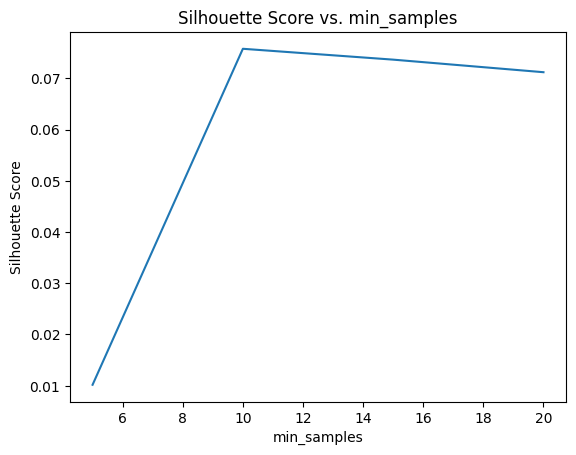

In [ ]:
#Find an optimal number for min-samples

from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

#Function to evaluate DBSCAN with different min_samples values
def Evaluate_DBSCAN(min_samples_values, eps=0.5):
    Scores = []
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(DataEncoded[ClusteringFeatures])

        #Calculate the silhouette score (excluding -1, which are considered noise)
        if len(set(labels)) > 1:
            score = silhouette_score(DataEncoded[ClusteringFeatures], labels)
            Scores.append(score)
        else:
            Scores.append(-1)
    return Scores

#Try different values
min_samples_values = [5, 10, 15, 20]
Scores = Evaluate_DBSCAN(min_samples_values, eps=0.5)

#Plot
plt.plot(min_samples_values, Scores)
plt.title('Silhouette Score vs. min_samples')
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')
plt.show()

Cluster Labels:
 Cluster_DBSCAN
 1    18445
 0    10135
 2     5479
-1     4962
 7     2618
 6     1290
 9      210
 4       18
 3       15
 8       11
 5       10
Name: count, dtype: int64


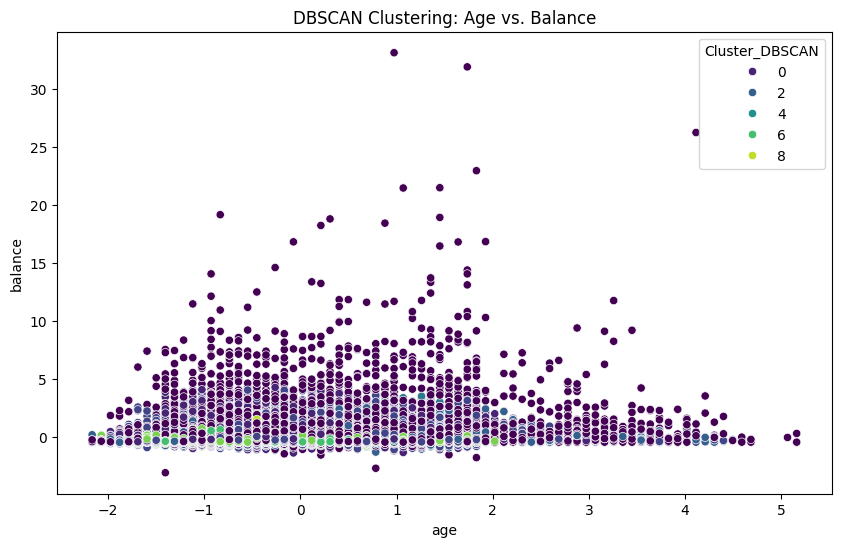

Silhouette Score: 0.0737


In [ ]:
#Apply DBSCAN Clustering

import seaborn as sns

#Configure parameters
eps = 0.5
min_samples = 15

#Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
DataEncoded['Cluster_DBSCAN'] = dbscan.fit_predict(DataEncoded[ClusteringFeatures])
print("Cluster Labels:\n", DataEncoded['Cluster_DBSCAN'].value_counts())

#Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='balance', hue='Cluster_DBSCAN', data=DataEncoded, palette='viridis')
plt.title('DBSCAN Clustering: Age vs. Balance')
plt.show()

#Evaluate clustering
if len(set(DataEncoded['Cluster_DBSCAN'])) > 1:
    silhouette = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_DBSCAN'])
    print(f"Silhouette Score: {silhouette:.4f}")
else:
    print("Silhouette Score cannot be calculated")

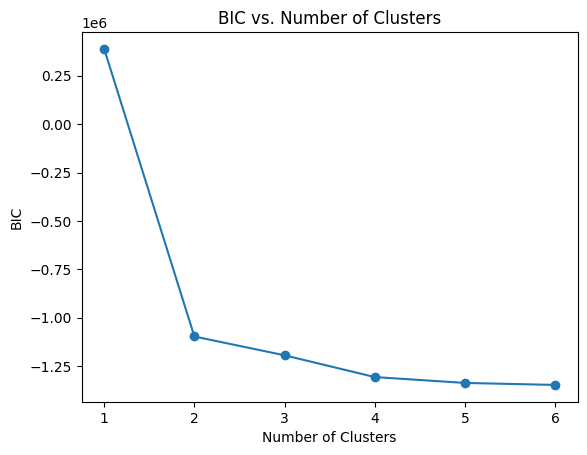

Optimal number of clusters (based on BIC): 6


In [ ]:
#Implement Elbow Method for GMM Using BIC

from sklearn.mixture import GaussianMixture

#Define a range of cluster numbers
MaxClusters = 6
BicScores = []

#Try different number of clusters (1 to MaxClusters)
for n in range(1, MaxClusters + 1):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(DataEncoded[ClusteringFeatures])
    BicScores.append(gmm.bic(DataEncoded[ClusteringFeatures]))

#Plot scores
plt.plot(range(1, MaxClusters + 1), BicScores, marker='o')
plt.title('BIC vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()

#Identify the optimal number of clusters
optimal_clusters = np.argmin(BicScores) + 1
print(f"Optimal number of clusters (based on BIC): {optimal_clusters}")

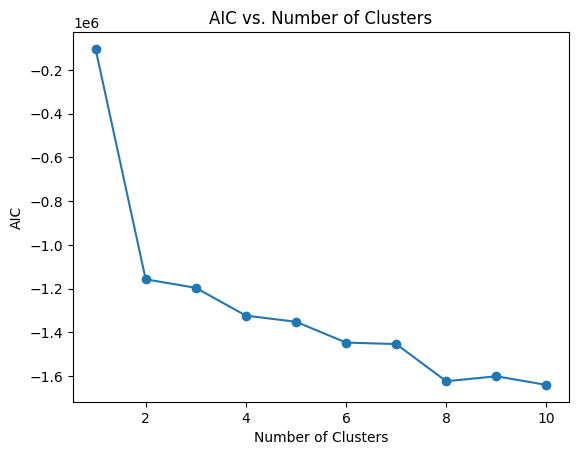

Optimal number of clusters (based on AIC): 10


In [ ]:
#Implement Elbow Method for GMM Using AIC

AicScores = []

#Try different number of clusters
for n in range(1, MaxClusters + 1):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(DataEncoded[ClusteringFeatures])
    AicScores.append(gmm.aic(DataEncoded[ClusteringFeatures]))

#Plot scores
plt.plot(range(1, MaxClusters + 1), AicScores, marker='o')
plt.title('AIC vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC')
plt.show()

#Identify the optimal number of clusters
optimal_clusters_aic = np.argmin(AicScores) + 1
print(f"Optimal number of clusters (based on AIC): {optimal_clusters_aic}")

Silhouette Score (GMM): 0.3822
Davies-Bouldin Index (GMM): 1.3097
Calinski-Harabasz Score (GMM): 7997.3161


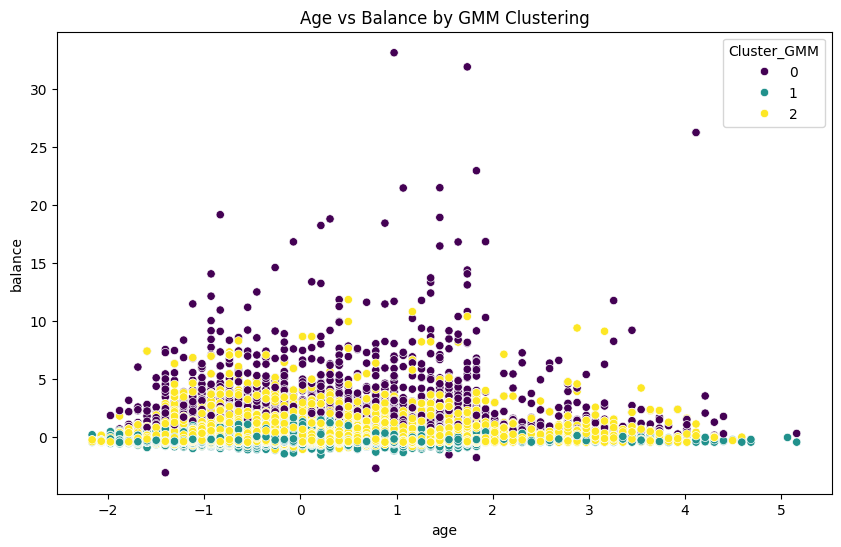

In [ ]:
#Apply Gaussian Mixture Models

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns

ClusteringFeatures = ['age', 'education', 'balance', 'campaign', 'pdays', 'previous',
                      'Contacted_before', 'AgeBalance']

#GMM with 3 clusters (the optimal number after trying different numbers from 1 to 10)
GMMModel = GaussianMixture(n_components=3, random_state=42)
DataEncoded['Cluster_GMM'] = GMMModel.fit_predict(DataEncoded[ClusteringFeatures])

#Evaluation Metrics
Silhouette_GMM = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM'])
DBI_GMM = davies_bouldin_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM'])
CH_GMM = calinski_harabasz_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM'])

#Print Evaluation Metrics
print(f"Silhouette Score (GMM): {Silhouette_GMM:.4f}")
print(f"Davies-Bouldin Index (GMM): {DBI_GMM:.4f}")
print(f"Calinski-Harabasz Score (GMM): {CH_GMM:.4f}")

#Visualize Clusters (Age vs Balance example)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='balance', hue='Cluster_GMM', data=DataEncoded, palette='viridis')
plt.title("Age vs Balance by GMM Clustering")
plt.show()

In [ ]:
#Fine-Tuning GMM with Different Covariance Types

#Try 'full' covariance (default)
GMM_full = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
DataEncoded['Cluster_GMM_full'] = GMM_full.fit_predict(DataEncoded[ClusteringFeatures])

#Try 'tied' covariance
GMM_tied = GaussianMixture(n_components=3, covariance_type='tied', random_state=42)
DataEncoded['Cluster_GMM_tied'] = GMM_tied.fit_predict(DataEncoded[ClusteringFeatures])

#Try 'diag' covariance
GMM_diag = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
DataEncoded['Cluster_GMM_diag'] = GMM_diag.fit_predict(DataEncoded[ClusteringFeatures])

#Try 'spherical' covariance
GMM_spherical = GaussianMixture(n_components=3, covariance_type='spherical', random_state=42)
DataEncoded['Cluster_GMM_spherical'] = GMM_spherical.fit_predict(DataEncoded[ClusteringFeatures])

#Evaluate and compare the Silhouette Scores
silhouette_full = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM_full'])
silhouette_tied = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM_tied'])
silhouette_diag = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM_diag'])
silhouette_spherical = silhouette_score(DataEncoded[ClusteringFeatures], DataEncoded['Cluster_GMM_spherical'])

print(f"Silhouette Score (Full): {silhouette_full:.4f}")
print(f"Silhouette Score (Tied): {silhouette_tied:.4f}")
print(f"Silhouette Score (Diag): {silhouette_diag:.4f}")
print(f"Silhouette Score (Spherical): {silhouette_spherical:.4f}")

Silhouette Score (Full): 0.3822
Silhouette Score (Tied): 0.2828
Silhouette Score (Diag): 0.3938
Silhouette Score (Spherical): 0.2056


In [ ]:
#Fine-Tuning GMM with different feature sets

#Different feature sets for testing
features_set_1 = ['age', 'balance', 'campaign', 'previous']
features_set_2 = ['age', 'balance', 'campaign', 'previous', 'AgeBalance']
features_set_3 = ['age', 'balance', 'campaign', 'previous', 'AgeBalance', 'ZeroBalance']

#GMM with Set 1
GMM_set_1 = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
DataEncoded['Cluster_GMM_set_1'] = GMM_set_1.fit_predict(DataEncoded[features_set_1])
silhouette_set_1 = silhouette_score(DataEncoded[features_set_1], DataEncoded['Cluster_GMM_set_1'])

#GMM with Set 2
GMM_set_2 = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
DataEncoded['Cluster_GMM_set_2'] = GMM_set_2.fit_predict(DataEncoded[features_set_2])
silhouette_set_2 = silhouette_score(DataEncoded[features_set_2], DataEncoded['Cluster_GMM_set_2'])

#GMM with Set 3
GMM_set_3 = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
DataEncoded['Cluster_GMM_set_3'] = GMM_set_3.fit_predict(DataEncoded[features_set_3])
silhouette_set_3 = silhouette_score(DataEncoded[features_set_3], DataEncoded['Cluster_GMM_set_3'])

#Print Silhouette Scores
print(f"Silhouette Score (Set 1 - No AgeBalance/ZeroBalance): {silhouette_set_1:.4f}")
print(f"Silhouette Score (Set 2 - With AgeBalance): {silhouette_set_2:.4f}")
print(f"Silhouette Score (Set 3 - With AgeBalance & ZeroBalance): {silhouette_set_3:.4f}")

Silhouette Score (Set 1 - No AgeBalance/ZeroBalance): 0.2080
Silhouette Score (Set 2 - With AgeBalance): 0.2176
Silhouette Score (Set 3 - With AgeBalance & ZeroBalance): 0.2176
